In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

In [13]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [14]:
#1 year prior to last date
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [15]:
# Perform a query to retrieve the data and precipitation scores

precip_data = session.query(Measurement.date, Measurement.prcp,).\
    filter(Measurement.date >= '2016-08-23').\
    order_by(Measurement.date).all()

In [16]:
precip_data

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

([], <a list of 0 Text xticklabel objects>)

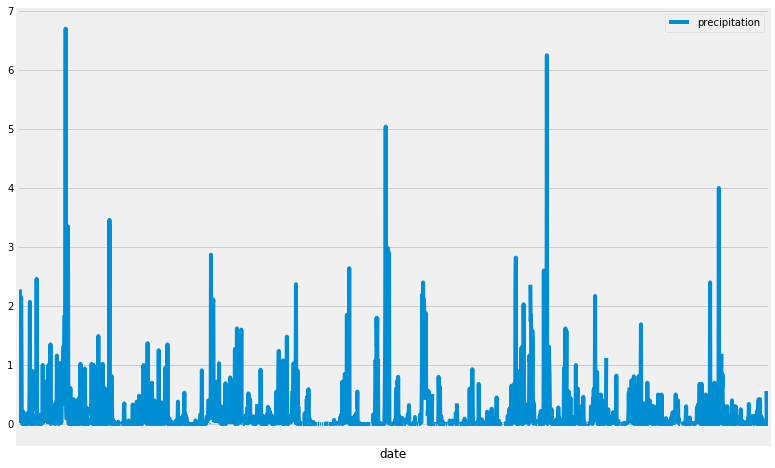

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precip_data)
df = df.rename(columns = {'prcp':'precipitation'})
df.set_index('date', inplace = True)
# Sort the dataframe by date
df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(y = 'precipitation', figsize = (12,8))
plt.xticks([])

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
description = df['precipitation'].describe()

In [19]:
pd.DataFrame(description)

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).\
    group_by(Measurement.station).count()

9

In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(Station.name, func.min(Measurement.tobs), 
                    func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station==Station.station).filter(Measurement.station == 'USC00519281').all()

[('WAIHEE 837.5, HI US', 54.0, 85.0, 71.66378066378067)]

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = session.query(Station.name, Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.station==Station.station).\
    order_by(Measurement.date).all()
data

[('WAIHEE 837.5, HI US', '2016-08-23', 77.0),
 ('WAIHEE 837.5, HI US', '2016-08-24', 77.0),
 ('WAIHEE 837.5, HI US', '2016-08-25', 80.0),
 ('WAIHEE 837.5, HI US', '2016-08-26', 80.0),
 ('WAIHEE 837.5, HI US', '2016-08-27', 75.0),
 ('WAIHEE 837.5, HI US', '2016-08-28', 73.0),
 ('WAIHEE 837.5, HI US', '2016-08-29', 78.0),
 ('WAIHEE 837.5, HI US', '2016-08-30', 77.0),
 ('WAIHEE 837.5, HI US', '2016-08-31', 78.0),
 ('WAIHEE 837.5, HI US', '2016-09-01', 80.0),
 ('WAIHEE 837.5, HI US', '2016-09-02', 80.0),
 ('WAIHEE 837.5, HI US', '2016-09-03', 78.0),
 ('WAIHEE 837.5, HI US', '2016-09-04', 78.0),
 ('WAIHEE 837.5, HI US', '2016-09-05', 78.0),
 ('WAIHEE 837.5, HI US', '2016-09-06', 73.0),
 ('WAIHEE 837.5, HI US', '2016-09-07', 74.0),
 ('WAIHEE 837.5, HI US', '2016-09-08', 80.0),
 ('WAIHEE 837.5, HI US', '2016-09-09', 79.0),
 ('WAIHEE 837.5, HI US', '2016-09-10', 77.0),
 ('WAIHEE 837.5, HI US', '2016-09-11', 80.0),
 ('WAIHEE 837.5, HI US', '2016-09-12', 76.0),
 ('WAIHEE 837.5, HI US', '2016-09-

Text(0.5, 0, 'Temperature (Farenheit)')

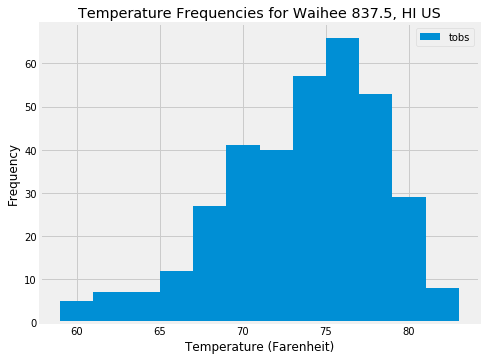

In [33]:
df = pd.DataFrame(data)
#df.set_index('date', inplace = True)
# Sort the dataframe by date
#df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(y = 'tobs', figsize = (7,5.5), kind = 'hist', bins = 12)
plt.title("Temperature Frequencies for Waihee 837.5, HI US")
plt.xlabel("Temperature (Farenheit)")

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-07-18', '2016-07-28'))

[(72.0, 78.15151515151516, 83.0)]


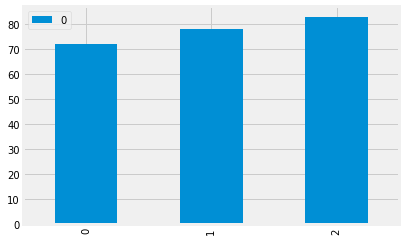

In [27]:
data = calc_temps('2016-07-18', '2016-07-28')
data = data[0]
data_as_list = []
for num in data:
    data_as_list.append(num)
data = data_as_list
df = pd.DataFrame(data)
df.plot(kind = 'bar')

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [33]:
# Plot the daily normals as an area plot with `stacked=False`
